# Offline ML 

## Goals:

1. **Data Import**
    - Import EEG data (with associated markers).
    - Import comfort bracket data.

2. **Preprocessing**
    - Preprocess the EEG data.
    - Epoch data based on stimulus appearance.
        - Tag each EEG epoch with the stimulus appearance and comfort score.

    - Convert the bracket data to scores with Elo and export to excel sheet

3. **Feature Extraction**
    - Calculate the Power Spectral Density (PSD) for each epoch.
    - Calculate the Z-score for each epoch:
        * **Formula**:   PSD Z-score = (PSD(single trial) - Mean PSD of baseline trials) / Std PSD of baseline trials
        
4. **Data Formatting**
    - Format data to feed it into the ML model.

Want to make this as light as possible so only a few tweaks need to be made to run this in real-time

# Import Libraries

In [1]:
# Import libraries
import mne
import json
import numpy as np

# Import custom scripts
from Functions import import_data
from Functions import data_tools
from Functions import elo


import pandas as pd
from openpyxl import load_workbook

from mne.preprocessing import ICA
from autoreject import Ransac 


# Enable interactive plots
%matplotlib qt

# Import Data

Import EEG data, should be a single file
- Set channel names
- Create an mne raw object (?)

Import bracket data
- Separate into matches (strings of stimulus names) and winners (string of stimulus name)


Creating RawArray with float64 data, n_channels=16, n_times=331520
    Range : 0 ... 331519 =      0.000 ...  1294.996 secs
Ready.
Using matplotlib as 2D backend.


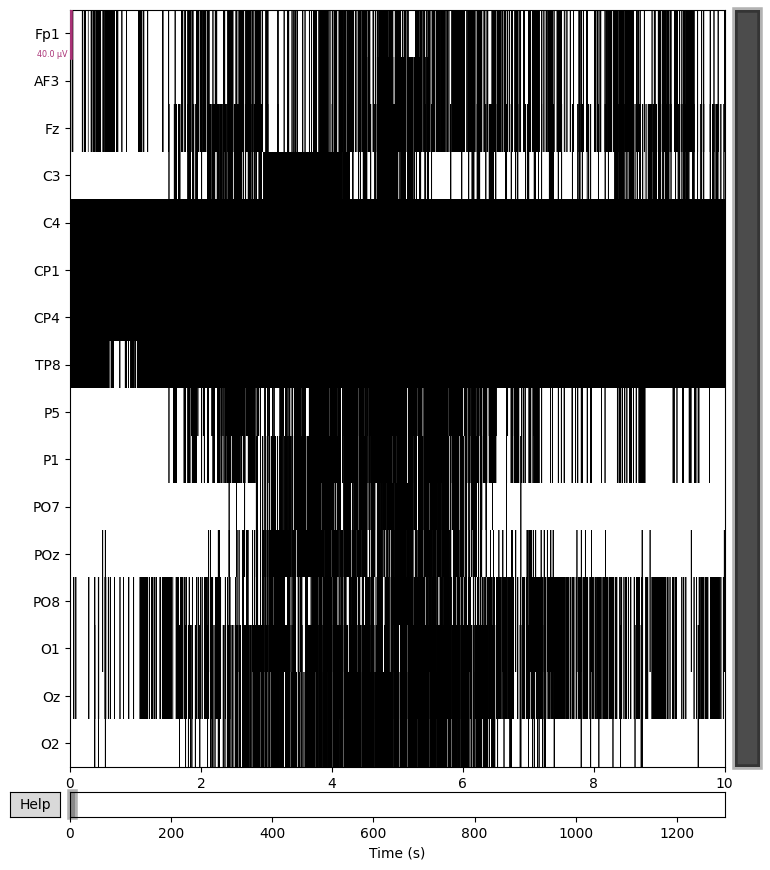

In [2]:
# import bracket data
bracket_data = pd.read_csv(r'Data/Masters_testing/P001-S001.csv')
matches = list(bracket_data[['Item 1', 'Item 2']].itertuples(index=False, name=None))
winners = bracket_data['Winner'].tolist()

# import EEG data
file_name = "Masters_testing/sub-P001_ses-S001_task-T1_run-001_eeg.xdf"
ch_names = ["Fp1", "Af3", "Fz", "C3", "C4", "Cp1", "Cp4", "Tp8", "P5", "P1", "PO7", "POz", "PO8", "O1", "Oz", "O2"]


# Import data 
[eeg_ts, eeg_data, eeg_fs] = import_data.read_xdf(f"Data\\{file_name}", picks=ch_names)

# Create MNE array
info = mne.create_info(ch_names, eeg_fs, ch_types = 'eeg')  # Create info properties

mne_raw = mne.io.RawArray(eeg_data, info = info)            # Create MNE raw array

# Fix mis-named channels
fixed_channels = {"Af3": "AF3", "Cp1": "CP1", "Cp4": "CP4", "Tp8": "TP8"}
mne_raw.rename_channels(fixed_channels)
updated_ch_names =  ["Fp1", "AF3", "Fz", "C3", "C4", "CP1", "CP4", "TP8", "P5", "P1", "PO7", "POz", "PO8", "O1", "Oz", "O2"]

# Set standard channel montage
mne_raw.set_montage('standard_1020')  

mne_raw.plot(title="RAW data")   

## Bandpass Filter Data

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 16.88 Hz)
- Filter length: 1691 samples (6.605 s)



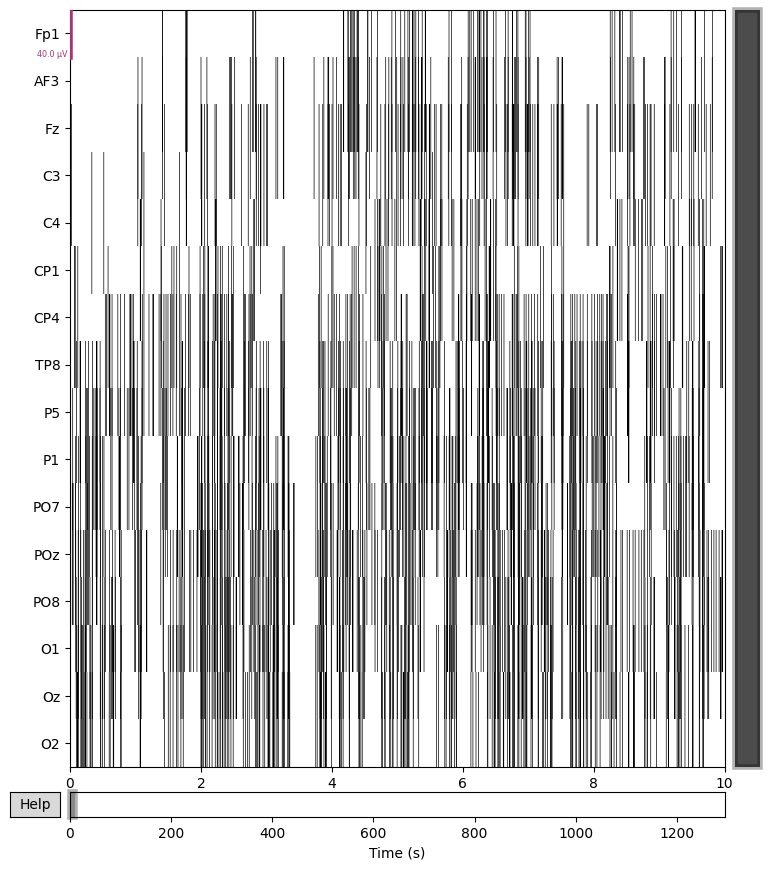

In [3]:
# Settings
hpf_fc = 0.5    # High-pass cut-off frequency: list[Hz]
lpf_fc = 15

# Apply high-pass filter
filt_raw = mne_raw.copy().filter(l_freq=hpf_fc, h_freq=lpf_fc, picks=updated_ch_names)
filt_raw.plot()

# ICA

Fitting ICA to data using 16 channels (please be patient, this may take a while)
Selecting by number: 16 components
Fitting ICA took 3.5s.
Variance explained
- Component 0: variance = 81% (BAD)
- Component 0: variance = 81%
- Component 1: variance = 13%
- Component 2: variance = 1%
- Component 3: variance = 1%
- Component 4: variance = 0%
- Component 5: variance = 1%
- Component 6: variance = 0%
- Component 7: variance = 0%
- Component 8: variance = 0%
Applying ICA to Raw instance
    Transforming to ICA space (16 components)
    Zeroing out 1 ICA component
    Projecting back using 16 PCA components


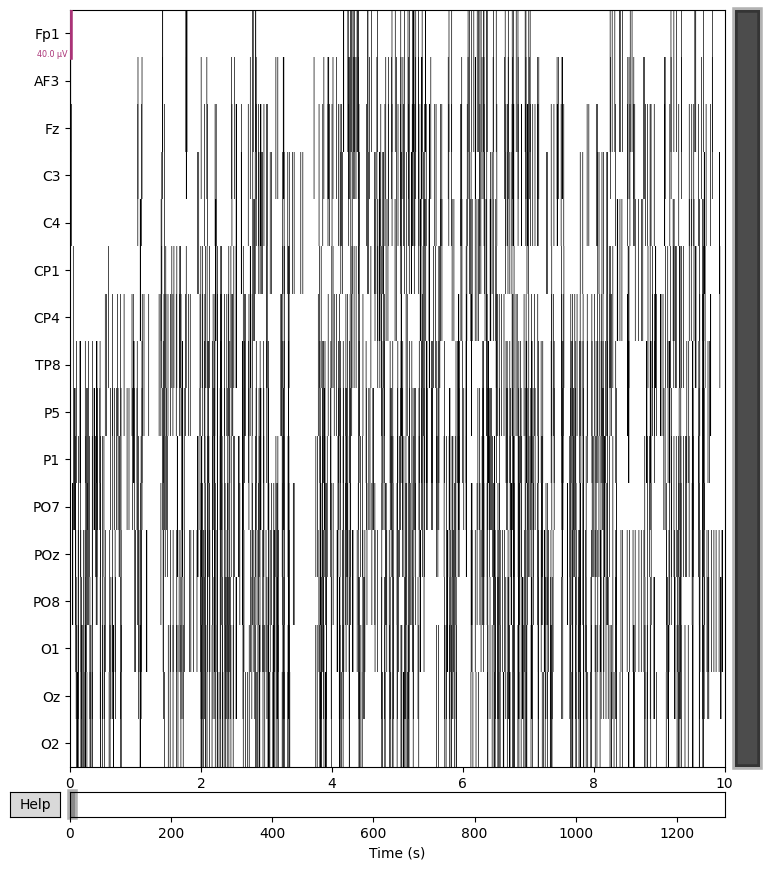

In [4]:
# Settings
n_components = len(filt_raw.ch_names)   # Number of components for ICA [n]
random_state = 97                       # Random state for reproducible results
max_iter = "auto"                       # Max number of iterations

# Create and apply ICA
ica = ICA(
    n_components = n_components,
    max_iter = max_iter,
    random_state = random_state
    )

ica.fit(filt_raw, picks = updated_ch_names)
ica

# Plot ICA components on interactive plot
#ica.plot_components()

# Settings 
ch_properties = [0,1,2,3,4,5,6,7,8]  # Channels to inspect list[int]
bad_components = []                  # Components to remove list[int]

# Plot ICA properties
#ica.plot_properties(filt_raw, picks = ch_properties, verbose = False)

# Compute amount of variance explained by each component to inspect
print("Variance explained")
for component in ch_properties:
    explained_var_ratio = ica.get_explained_variance_ratio(
        filt_raw, 
        components=component,
        ch_type="eeg"
    )
    
    ratio_percent = round(100 * explained_var_ratio["eeg"])
    if ratio_percent > 50:
        bad_components.append(component)
        print(f"- Component {component}: variance = {ratio_percent}% (BAD)")
    print(f"- Component {component}: variance = {ratio_percent}%")


# Remove components
ica_raw = filt_raw.copy()
ica.exclude = bad_components
ica.apply(ica_raw)

# Plot before and after ICA to compare
#filt_raw.plot(title="BPF before ICA")
#ica_raw.plot(title="BPF after ICA")

# Automatically Detect Bad Channels?
ransac: https://autoreject.github.io/stable/auto_examples/plot_ransac.html

In [5]:
# Initialize RANSAC for bad channel detection
# min_cor: Minimum correlation between channels to be considered as a good channel
# n_resample: Number of resamples to use for RANSAC
# min_channels: Minimum number of channels to be considered as a good channel
ransac = Ransac(verbose=True, picks="eeg", n_jobs=1, min_corr= 0.75, n_resample = 100, min_channels = 0.25)

# Create epochs with preloading enabled
epochs = mne.make_fixed_length_epochs(ica_raw, duration=2, overlap=0.5, preload=True)

# Fit RANSAC to detect bad channels
ransac.fit(epochs)

# Print the identified bad channels
bad_channels = ransac.bad_chs_
print("Bad channels detected by RANSAC:")
print('\n'.join(bad_channels))

# Plot the evoked data before removing bad channels
evoked_before = epochs.average()
fig_before = evoked_before.plot(ylim={"eeg": (-5000000, 5000000)})  # Set Y-axis limits for EEG channels
fig_before.suptitle("Evoked Data (Before Removing Bad Channels)", fontsize=16)

# Remove bad channels from the raw object
ica_raw_clean = ica_raw.copy().drop_channels(bad_channels)

# Create new epochs without bad channels
epochs_clean = mne.make_fixed_length_epochs(ica_raw_clean, duration=2, overlap=0.5, preload=True)

# Plot the evoked data after removing bad channels
evoked_after = epochs_clean.average()
fig_after = evoked_after.plot(ylim={"eeg": (-5000000, 5000000)})
fig_after.suptitle("Evoked Data (After Removing Bad Channels)", fontsize=16)


Not setting metadata
863 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 863 events and 512 original time points ...
0 bad epochs dropped


  0%|          | interpolating channels : 0/100 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s


  0%|          | Iterating epochs : 0/863 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   16.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   16.1s


[Done]
Bad channels detected by RANSAC:
C4
CP4
TP8
Not setting metadata
863 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 863 events and 512 original time points ...
0 bad epochs dropped


Text(0.5, 0.98, 'Evoked Data (After Removing Bad Channels)')

# Epoch Data
Want to epoch the EEG data based on stimulus labels

This can look like 
1. [EEG]
2. [Stimulus Labels]
3. [Comfort Labels]

In [ ]:
# Import markers
[marker_ts, markers] = import_data.read_xdf_unity_markers(f"Data\{file_name}")    # Import markers

# Create epochs from Unity markerts
(eeg_epochs, epoch_labels) = data_tools.epochs_from_unity_markers(
    eeg_time = eeg_ts,
    eeg_data = filt_raw.get_data(),
    marker_time = marker_ts,
    marker_data = markers
    )

# Get stimuli and frequencies labels
dict_of_stimuli = data_tools.get_tvep_stimuli(epoch_labels) # Dictionary of unique stimulus
dict_of_freqs = {0:"10"} 

# Create array of eeg epochs organized as [stimuli, freq, chans, samples]
eeg_epochs_organized = data_tools.epochs_stim_freq(
    eeg_epochs = eeg_epochs,
    labels = epoch_labels,
    stimuli = dict_of_stimuli,
    freqs = dict_of_freqs
    )

# ELO Ranking

In [ ]:
# Instantiate Elo Ranking object
elo_system = elo.EloRanking()

# Process matches and their winners
for (competitor1, competitor2), winner in zip(matches, winners):
    loser = competitor1 if winner == competitor2 else competitor2
    elo_system.update_ratings(winner, loser)

# Rankings before post-hoc adjustment
print("Rankings before adjustment:")
print(pd.DataFrame(elo_system.get_rankings(), columns=["Stimulus", "Rating"]))

# Apply post-hoc adjustment
elo_system.post_hoc_adjustment()

# Rankings after post-hoc adjustment
print("\nRankings after adjustment:")
print(pd.DataFrame(elo_system.get_rankings(), columns=["Stimulus", "Rating"]))

# Scores after standardization from 1 - 10
elo_system.standardize_rankings()
print("\n Standardized scores")
print(pd.DataFrame(elo_system.get_scores(), columns=["Stimulus", "Scores"]))

# Export the rankings to the data sheet


# Compute PSD for all Epochs

Make sure to include baseline epochs for later calculation of Z-score

# Compute Z-score For Each Epoch
This will create a fourth array [Z-scores]

# Remove "Off" Epochs for ML

# Run ML Model
Choose several and test which has the best performance

Decide on:
- Train/test split
- Which models to use
    * https://scikit-learn.org/stable/auto_examples/neighbors/plot_regression.html#sphx-glr-auto-examples-neighbors-plot-regression-py
    * https://scikit-learn.org/stable/modules/svm.html
    * https://scikit-learn.org/stable/modules/neural_networks_supervised.html
- How to input all data
- How to get the output I desire

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Simulate EEG data (replace with actual data loading)
# Example: 1000 samples, each with 128 time steps, and 8 EEG channels
eeg_data = np.random.rand(1000, 128, 8)  # Shape: (samples, time steps, features)
stimulus_rankings = np.random.randint(1, 6, size=(1000,))  # Comfort rankings (1 to 5)

# Normalize EEG data
scaler = StandardScaler()
eeg_data = eeg_data.reshape(-1, eeg_data.shape[-1])  # Flatten for scaling
eeg_data = scaler.fit_transform(eeg_data)
eeg_data = eeg_data.reshape(-1, 128, 8)  # Reshape back

# Split data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(eeg_data, stimulus_rankings, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Convert rankings to one-hot if classification is needed
y_train_one_hot = tf.keras.utils.to_categorical(y_train - 1, num_classes=5)
y_val_one_hot = tf.keras.utils.to_categorical(y_val - 1, num_classes=5)
y_test_one_hot = tf.keras.utils.to_categorical(y_test - 1, num_classes=5)

# Build the LSTM model
model = Sequential([
    LSTM(64, input_shape=(128, 8), return_sequences=False),
    Dense(32, activation='relu'),
    Dense(5, activation='softmax')  # Use softmax for classification, or change to a single neuron for regression
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',  # Use 'mse' for regression
              metrics=['accuracy'])  # Use ['mae'] for regression

# Train the model
history = model.fit(X_train, y_train_one_hot, 
                    validation_data=(X_val, y_val_one_hot),
                    epochs=20, batch_size=32, verbose=1)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test_one_hot)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Save the model
model.save("eeg_lstm_model.h5")



# SVM Info

As other classifiers, SVC, NuSVC and LinearSVC take as input two arrays: an array X of shape (n_samples, n_features) holding the training samples, 
and an array y of class labels (strings or integers), of shape (n_samples):

Support Vector Machine algorithms are not scale invariant, so it is highly recommended to scale your data. For example, scale each attribute on the input vector X to [0,1] or [-1,+1],
or standardize it to have mean 0 and variance 1. Note that the same scaling must be applied to the test vector to obtain meaningful results. This can be done easily by using a Pipeline

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# Simulate example dataset
data = pd.DataFrame({
    "Epoch_Features": [np.random.rand(32, 1280) for _ in range(24)],  # 32 channels, 1280 time points (sampling rate = 128 * 10 for 10 sec)
    "Size": [1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3], 
    "Contrast": [1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4],  
    "Comfort_Score": [2, 3, 4, 7, 2, 4, 6, 7, 2, 4, 5, 7, 2, 3, 4, 6, 2, 4, 6, 7, 4, 4, 5, 7],  
    "Z_Score": [2.1, 3, 2.2, 2.2, 2.2, 2.1, 1.5, 1, 3, 3, 4, 2.1, 2.1, 3, 2.2, 2.2, 2.2, 2.1, 1.5, 1, 3, 3, 4, 2.1]  
})

# Filter by Z-Score
filtered_data = data[data['Z_Score'] > 2.0]

# Flatten EEG features
flattened_features = np.array([epoch.flatten() for epoch in filtered_data['Epoch_Features']])

# Combine features
X = np.hstack([
    flattened_features,
    filtered_data[['Size', 'Contrast']].values
])
y = filtered_data['Comfort_Score'].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split (to retain indices for Size/Contrast output)
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
    X_scaled, y, range(len(y)), test_size=0.2, random_state=42
)

# Get the corresponding Size and Contrast for the test set using test_indices
test_data = filtered_data.iloc[test_indices]
test_sizes = test_data['Size'].values
test_contrasts = test_data['Contrast'].values

# Define SVM model
model = SVR(kernel='rbf', C=1.0, gamma='scale')

# Cross-validation prediction
y_pred_cv = cross_val_predict(model, X_scaled, y, cv=10)  # 10-fold cross-validation

# Extract predictions only for the test set
y_pred_test = y_pred_cv[test_indices]

# Print out the Size, Contrast, and Prediction for each test epoch
for i in range(len(y_pred_test)):
    print(f"Prediction: {y_pred_test[i]}, Size: {test_sizes[i]}, Contrast: {test_contrasts[i]}")

# Calculate RMSE for the cross-validation predictions on the test set
rmse_cv = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"RMSE (Cross-Validation): {rmse_cv}")

print(f"Training epochs: {len(X_train)}")
print(f"Testing epochs: {len(X_test)}")
